In [4]:
import glob
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
from lsst.daf.persistence import Butler
import lsst.afw.image as afwImage
from lsst.afw.table import BaseCatalog
from astropy.table import vstack, Table
from astropy.visualization import ZScaleInterval
from astropy.coordinates import SkyCoord
from astropy import units as u
import data_process_utils as dpu
import imp
imp.reload(dpu) 

<module 'data_process_utils' from '/global/cscratch1/sd/shl159/projects/fake_injection_summer_2022/dia_improvement/devel/data_process_utils.py'>

In [5]:
interval = ZScaleInterval()

In [6]:
!pwd

/global/cscratch1/sd/shl159/projects/fake_injection_summer_2022/dia_improvement/devel


In [7]:
psf_table = Table.read('psf_table.csv', format='ascii.csv')

In [8]:
len(psf_table)

70

In [9]:
psf_table['psf_ratio'] = (psf_table['calexp_fwhm'] - psf_table['coadd_fwhm']) / psf_table['coadd_fwhm']    

In [10]:
len(psf_table[psf_table['psf_ratio']>=0])

30

In [11]:
len(psf_table[np.logical_and(psf_table['psf_ratio']<0, psf_table['psf_ratio']>=-0.05)])

16

In [12]:
len(psf_table[psf_table['psf_ratio']<-0.05])

24

In [13]:
base_flags = ['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter', 'base_PixelFlags_flag_suspect',
              'base_PixelFlags_flag_suspectCenter', 'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge',
              'base_PixelFlags_flag_bad', 'base_NaiveCentroid_flag']
dipole_flags = ['ip_diffim_DipoleFit_flag_classification', 'ip_diffim_DipoleFit_flag_classificationAttempted']
full_detections = Table.read('full_detections.csv', format='ascii.csv')
for flag in (base_flags+dipole_flags):
    full_detections[flag] = (full_detections[flag].data == 'True')

In [14]:
len(full_detections)

3788

In [15]:
full_detections['psf_ratio'] = (full_detections['calexp_fwhm'] - full_detections['coadd_fwhm']) / full_detections['coadd_fwhm']
full_detections['diaSrc_snr'] = full_detections['base_PsfFlux_instFlux'] / full_detections['base_PsfFlux_instFluxErr']
full_artifacts = full_detections[full_detections['diaSrc_snr']<60]

/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/astropy/table/column.py:991: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


In [19]:
base_rm = dpu.remove_flag_astropy(full_artifacts, flag_list=base_flags)

In [20]:
# 1134 after base flag

In [62]:
len(full_detections), len(full_artifacts), len(base_rm)

(3788, 2265, 1134)

In [63]:
# matched fraction
np.sum(full_artifacts['matched_status'] == 'True'), len(full_artifacts)

(2097, 2265)

In [64]:
2097 / 2265

0.9258278145695364

In [65]:
# psf width
broad = full_artifacts[full_artifacts['psf_ratio']>=0]
near = full_artifacts[np.logical_and(full_artifacts['psf_ratio']<0, full_artifacts['psf_ratio']>=-0.05)]
narrow = full_artifacts[full_artifacts['psf_ratio']<-0.05]

In [66]:
len(broad), len(near), len(narrow)

(751, 508, 1006)

In [67]:
751 + 508 + 1006

2265

In [68]:
broad_base_rm = dpu.remove_flag_astropy(broad, flag_list=base_flags)
near_base_rm = dpu.remove_flag_astropy(near, flag_list=base_flags)
narrow_base_rm = dpu.remove_flag_astropy(narrow, flag_list=base_flags)

In [69]:
len(broad_base_rm), len(near_base_rm), len(narrow_base_rm)

(417, 249, 468)

In [70]:
417 + 249 + 468

1134

In [73]:
# sat fraction
(751 - 417) / 751, (508 - 249) / 508,  (1006 - 468) / 1006

(0.4447403462050599, 0.5098425196850394, 0.5347912524850894)

In [71]:
broad_dipole_rm = dpu.remove_flag_astropy(broad_base_rm, flag_list=dipole_flags)
near_dipole_rm = dpu.remove_flag_astropy(near_base_rm, flag_list=dipole_flags)
narrow_dipole_rm = dpu.remove_flag_astropy(narrow_base_rm, flag_list=dipole_flags)

In [72]:
len(broad_dipole_rm), len(near_dipole_rm), len(narrow_dipole_rm)

(275, 148, 260)

In [74]:
# dipole fraction
(417 - 275) / 751, (249 - 148) / 508,  (468 - 260) / 1006

(0.18908122503328895, 0.19881889763779528, 0.20675944333996024)

In [75]:
# remaining fraction
(275) / 751, (148) / 508,  (260) / 1006

(0.36617842876165113, 0.29133858267716534, 0.2584493041749503)

# unmatched

In [60]:
unmatched = base_rm[base_rm['matched_status'] == 'False']

In [40]:
def display_artifacts(daiSrc_table, title):
    fig, ax = plt.subplots(2, 2, figsize=(5, 5))
    #fig.subplots_adjust(hspace=hspace)
    ax_ls = ax.flat

    for i, diaSrc in enumerate(daiSrc_table):
        diff_exp = afwImage.ExposureF(diaSrc['diffexp_path'])
        x = diaSrc['base_NaiveCentroid_x']
        y = diaSrc['base_NaiveCentroid_y']
        diff_stamp = dpu.make_cutout(diff_exp, x, y, cutout_size=30)
        ax_ls[i].imshow(interval(diff_stamp.getImage().array), cmap='gray', origin='lower')
        ax_ls[i].axis('off')
    plt.suptitle(title, y=0.95, size=20)

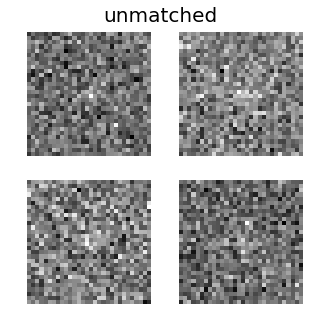

In [46]:
display_artifacts(unmatched[[9,1,8,7]], 'unmatched')
plt.savefig('6_unmatched.png', dpi=1000)